             Datetime  Energy_Production
0 2024-01-01 00:00:00          58.378372
1 2024-01-01 00:10:00          58.860321
2 2024-01-01 00:20:00          58.536825
3 2024-01-01 00:30:00          62.361299
4 2024-01-01 00:40:00          54.547307


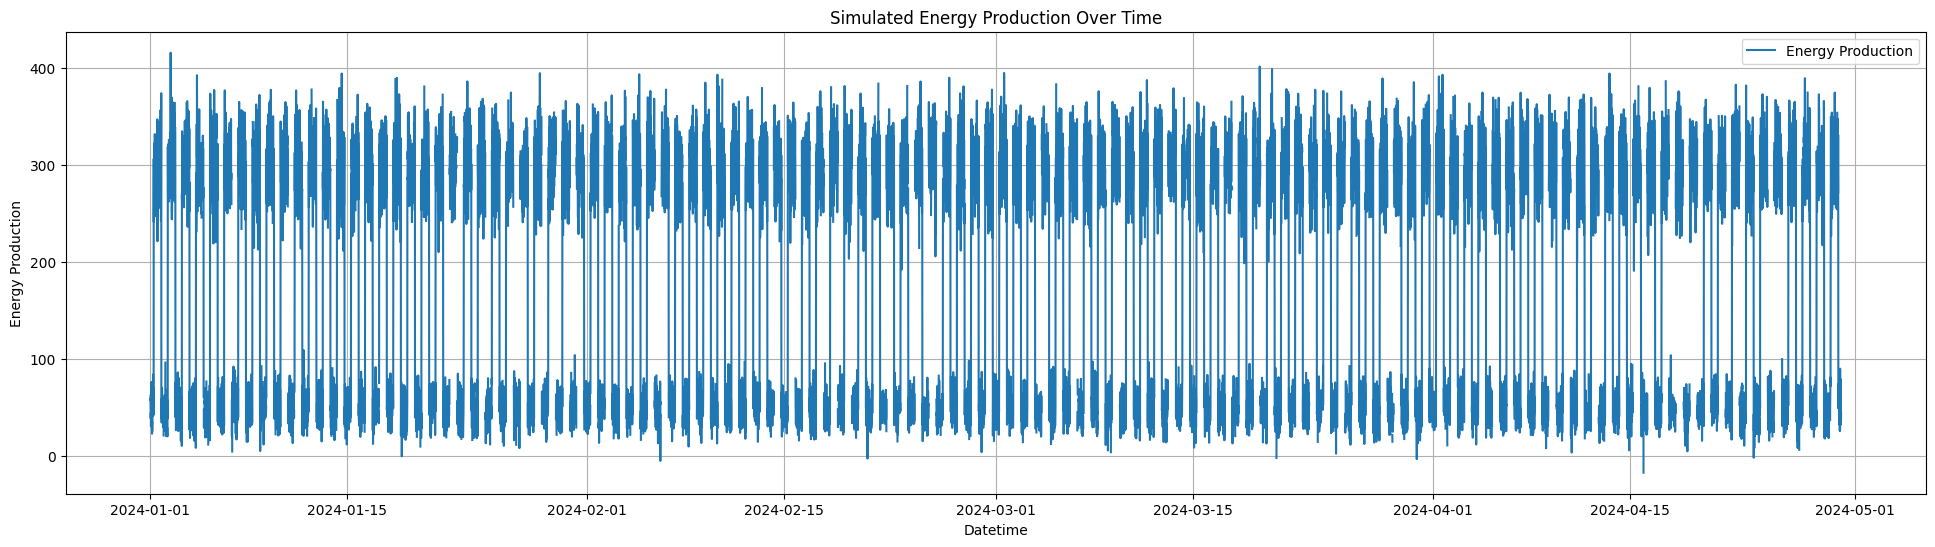

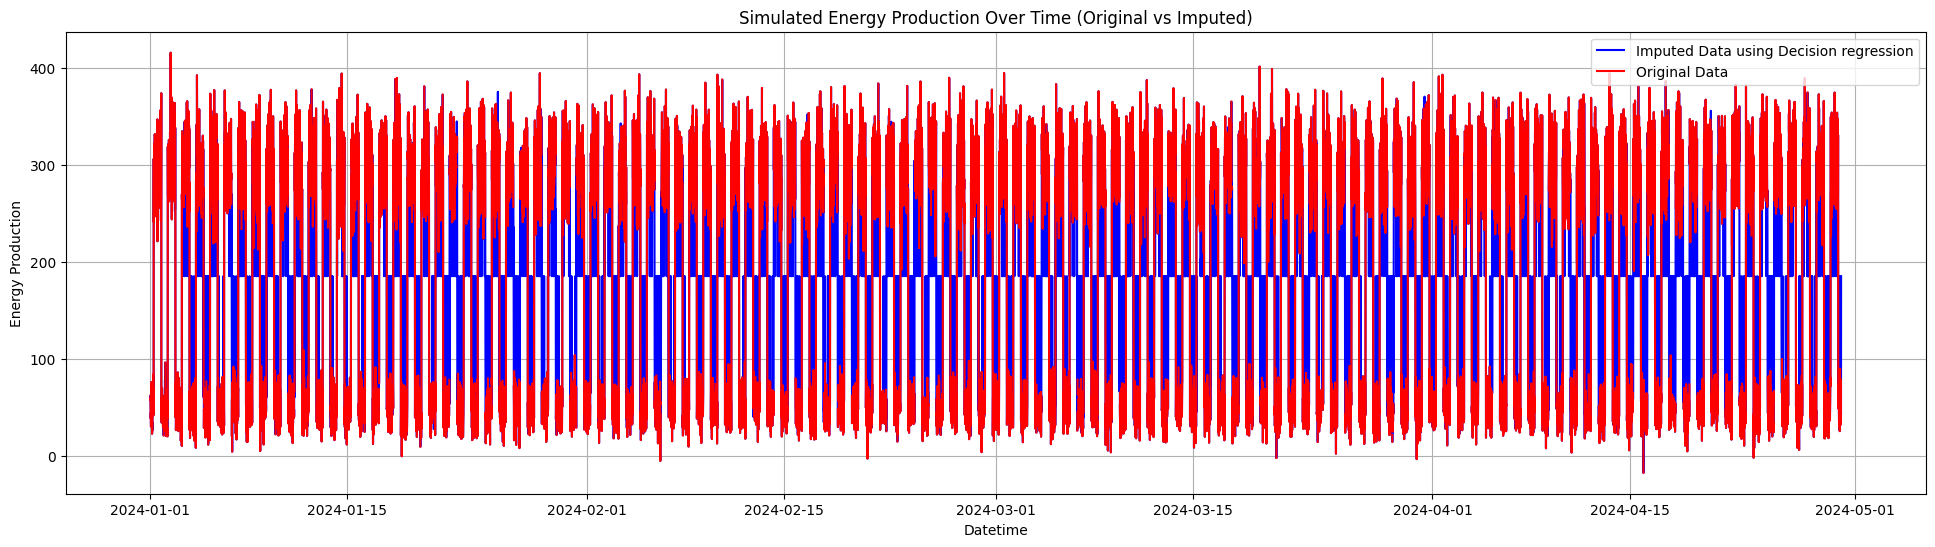

  Metric  Original Data  Imputed Data
0  count   15553.000000  17281.000000
1   mean     185.155737    185.170568
2    std     127.062030    120.682665
3    min     -16.984058    -16.984058
4    25%      51.260972     53.345570
5    50%     257.313693    185.457881
6    75%     302.393653    298.754461
7    max     415.581945    415.581945


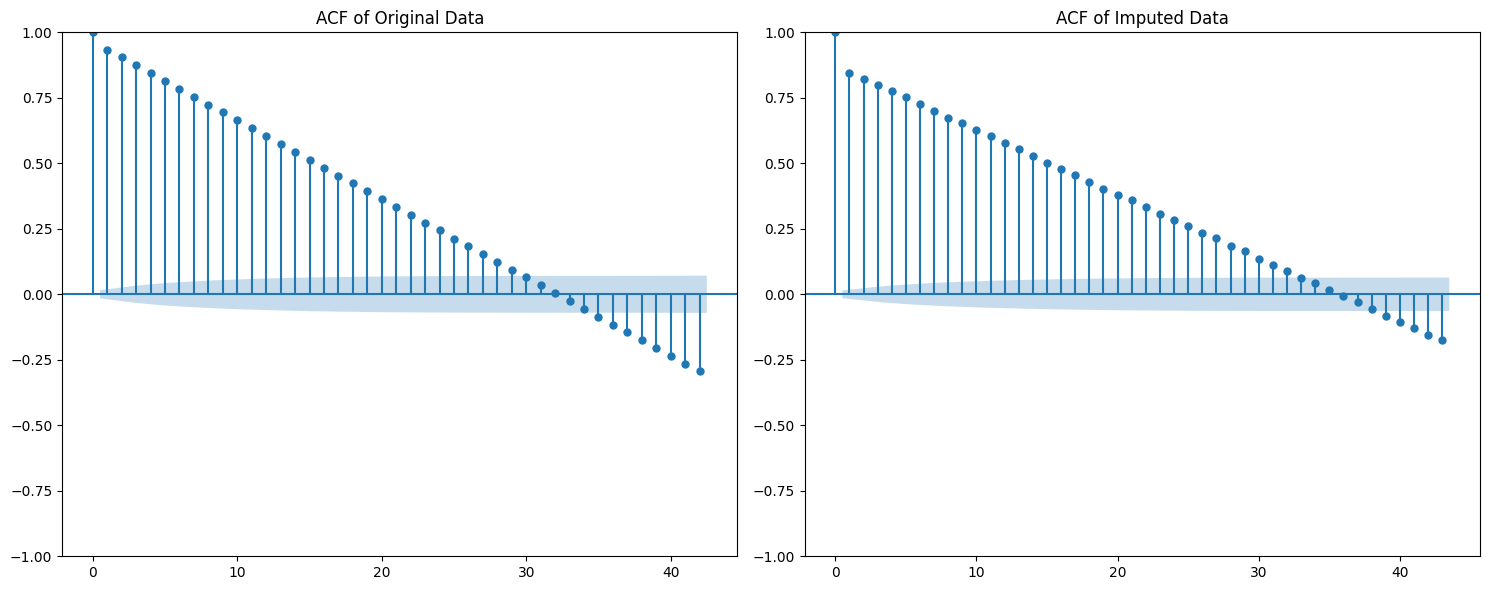

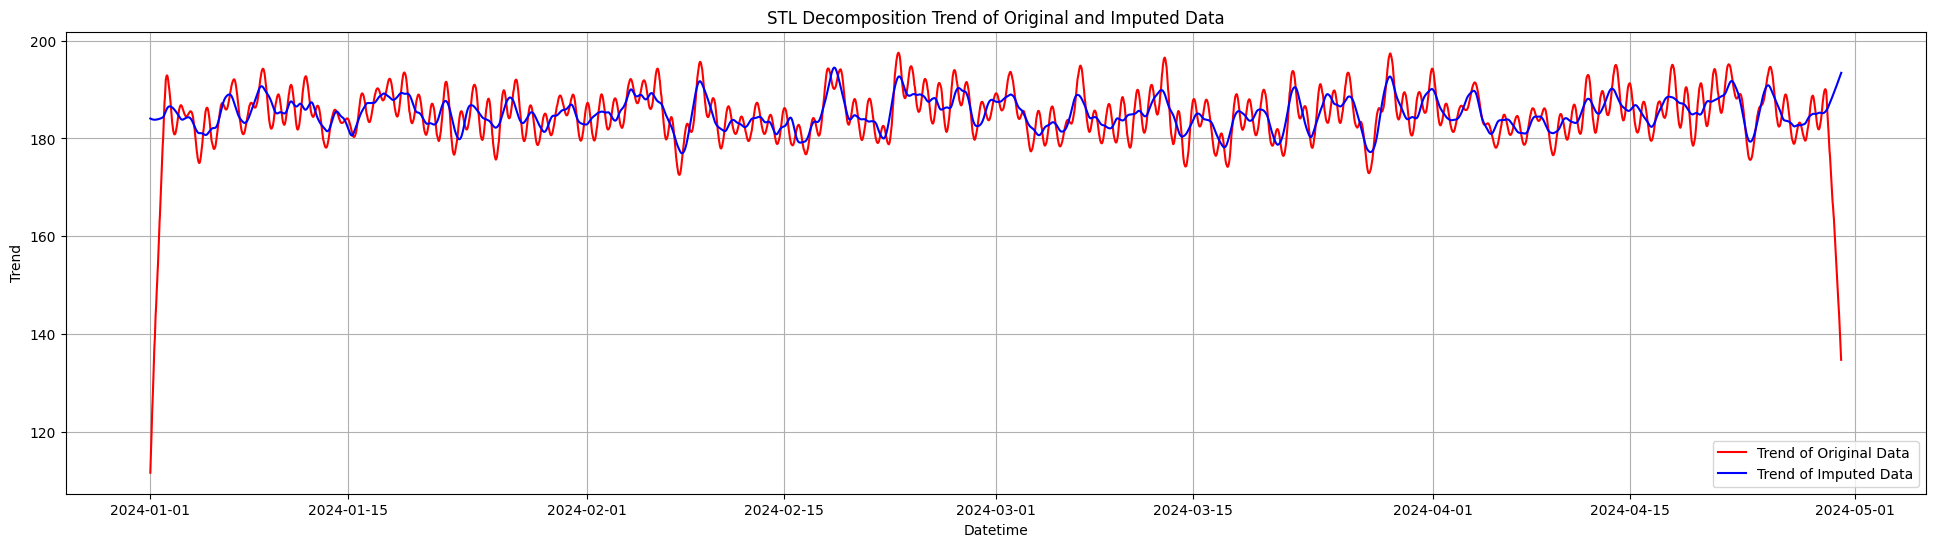

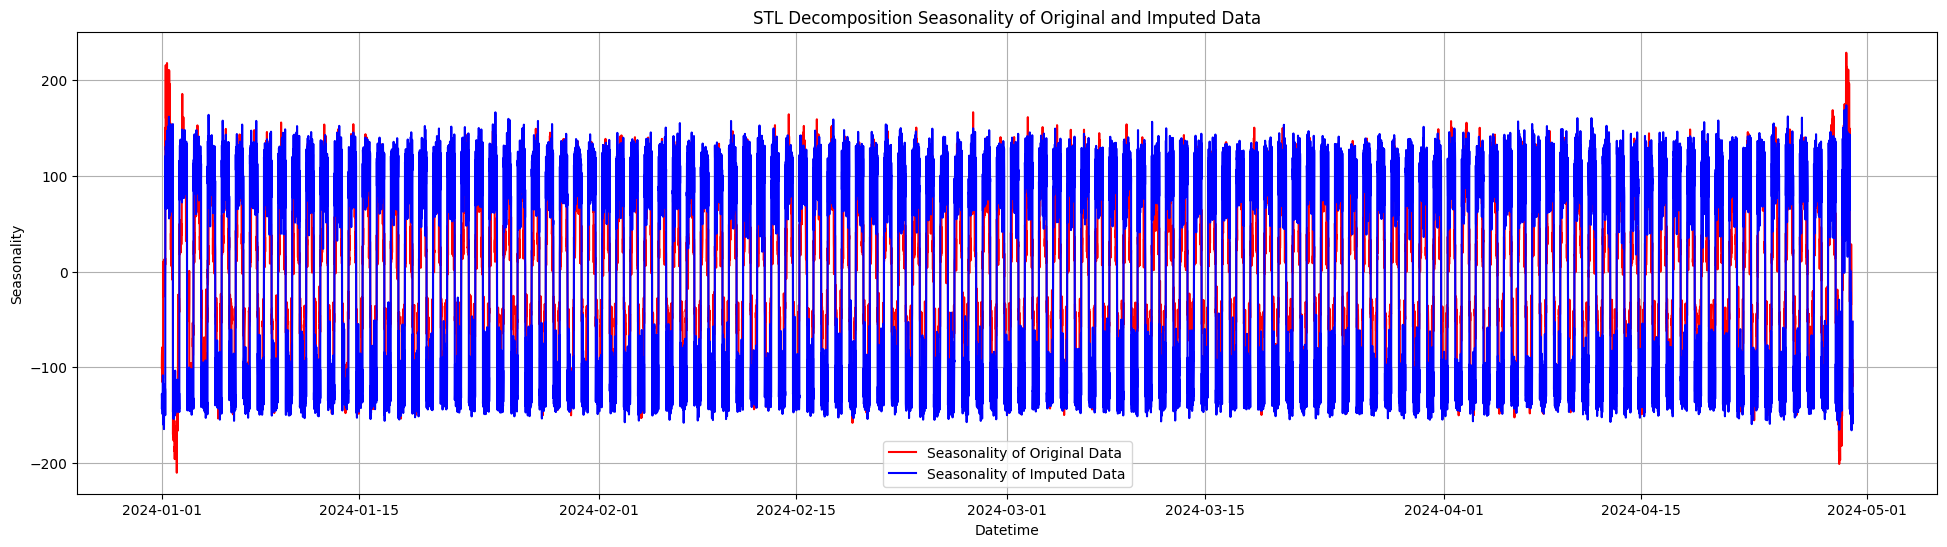

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Simulate mock energy production dataset
def simulate_energy_data(start_date, end_date, freq='10min'):
    # Create a datetime index with 10-minute intervals
    datetime_index = pd.date_range(start=start_date, end=end_date, freq=freq)

    # Simulate energy production with day-night cycles
    np.random.seed(42)  # For reproducibility
    hours = datetime_index.hour
    day_energy = np.random.normal(loc=300, scale=30, size=len(hours))
    night_energy = np.random.normal(loc=50, scale=15, size=len(hours))
    energy_values = np.where((hours >= 6) & (hours <= 18), day_energy, night_energy)

    # Introduce missing values (10% of the dataset)
    num_missing = int(0.1 * len(energy_values))  # 10% of data will be missing
    missing_indices = np.random.choice(len(energy_values), num_missing, replace=False)
    energy_values[missing_indices] = np.nan  # Set randomly selected indices to NaN

    # Create DataFrame with the simulated energy data
    energy_data = pd.DataFrame({
        'Datetime': datetime_index,
        'Energy_Production': energy_values
    })

    return energy_data
from sklearn.tree import DecisionTreeRegressor

# Impute missing values using linear regression
def impute_missing_values(data):
    # Extract the non-missing data
    non_missing_data = data.dropna()

    # Prepare the features (X) and target (y)
    X = non_missing_data.index.values.reshape(-1, 1)
    y = non_missing_data['Energy_Production'].values

    # Fit the linear regression model
    model =   DecisionTreeRegressor(max_depth=5, random_state=42)
    model.fit(X, y)

    # Predict the missing values
    missing_data = data[data['Energy_Production'].isna()]
    X_missing = missing_data.index.values.reshape(-1, 1)
    predicted_values = model.predict(X_missing)

    # Create a DataFrame for the imputed data
    imputed_data = data.copy()
    imputed_data.loc[data['Energy_Production'].isna(), 'Energy_Production'] = predicted_values

    return imputed_data
from statsmodels.graphics.tsaplots import plot_acf
# Autocorrelation analysis function

def autocorrelation_analysis(original_data, imputed_data):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    plot_acf(original_data['Energy_Production'].dropna(), ax=axes[0], title='ACF of Original Data')
    plot_acf(imputed_data['Energy_Production'], ax=axes[1], title='ACF of Imputed Data')
    plt.tight_layout()
    plt.show()

# Statistical comparison function using describe
def statistical_comparison(original_data, imputed_data):
    original_stats = original_data['Energy_Production'].describe()
    imputed_stats = imputed_data['Energy_Production'].describe()
    comparison = pd.DataFrame({
        'Metric': original_stats.index,
        'Original Data': original_stats.values,
        'Imputed Data': imputed_stats.values
    })
    return comparison

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose


# STL decomposition function to extract and plot trend component
def stl_decomposition_trend(original_data, imputed_data, period):
    stl_original = STL(original_data['Energy_Production'] , period=period)
    result_original = stl_original.fit()
    trend_original = result_original.trend

    stl_imputed = STL(imputed_data['Energy_Production'], period=period)
    result_imputed = stl_imputed.fit()
    trend_imputed = result_imputed.trend

    plt.figure(figsize=(24, 6))
    plt.plot(original_data['Datetime'], trend_original, label='Trend of Original Data', color='red')
    plt.plot(imputed_data['Datetime'], trend_imputed, label='Trend of Imputed Data', color='blue')
    plt.xlabel('Datetime')
    plt.ylabel('Trend')
    plt.title('STL Decomposition Trend of Original and Imputed Data')
    plt.legend()
    plt.grid(True)
    plt.show()


def stl_decomposition_seasonality(original_data, imputed_data, period):
    stl_original = STL(original_data['Energy_Production'], period=period)
    result_original = stl_original.fit()
    seasonality_original = result_original.seasonal

    stl_imputed = STL(imputed_data['Energy_Production'], period=period)
    result_imputed = stl_imputed.fit()
    seasonality_imputed = result_imputed.seasonal

    plt.figure(figsize=(24, 6))
    plt.plot(original_data['Datetime'], seasonality_original, label='Seasonality of Original Data', color='red')
    plt.plot(imputed_data['Datetime'], seasonality_imputed, label='Seasonality of Imputed Data', color='blue')
    plt.xlabel('Datetime')
    plt.ylabel('Seasonality')
    plt.title('STL Decomposition Seasonality of Original and Imputed Data')
    plt.legend()
    plt.grid(True)
    plt.show()



def plot_origin_data(energy_data_with_missing):
    plt.figure(figsize=(24, 6))
    plt.plot(energy_data_with_missing['Datetime'], energy_data_with_missing['Energy_Production'], label='Energy Production')
    plt.xlabel('Datetime')
    plt.ylabel('Energy Production')
    plt.title('Simulated Energy Production Over Time')
    plt.legend()

    plt.grid(True)
    plt.show()

def plot_full_data(energy_data_imputed,energy_data_with_missing):
    plt.figure(figsize=(24, 6))

    plt.plot(energy_data_imputed['Datetime'], energy_data_imputed['Energy_Production'], label='Imputed Data using Decision regression', color='blue' )
    plt.plot(energy_data_with_missing['Datetime'], energy_data_with_missing['Energy_Production'], label='Original Data', color='red')
    plt.xlabel('Datetime')
    plt.ylabel('Energy Production')
    plt.title('Simulated Energy Production Over Time (Original vs Imputed)')
    plt.legend()
    plt.grid(True)
    plt.show()
# Main script
if __name__ == "__main__":

    start_date = datetime(2024, 1, 1)
    end_date = datetime(2024, 4, 30)

    # Generate the simulated dataset
    energy_data_with_missing = simulate_energy_data(start_date, end_date)

    # Impute the missing values
    energy_data_imputed = impute_missing_values(energy_data_with_missing.copy())

    # Display the first few rows of the dataset
    print(energy_data_imputed.head())

    plot_origin_data(energy_data_with_missing)

    plot_full_data(energy_data_imputed,energy_data_with_missing)

    # Perform statistical comparison
    comparison = statistical_comparison(energy_data_with_missing.dropna(), energy_data_imputed)
    print(comparison)

    autocorrelation_analysis(energy_data_with_missing, energy_data_imputed)



    # Perform STL decomposition
    stl_decomposition_trend(energy_data_with_missing.dropna(), energy_data_imputed, period=144)  # Daily seasonality (144 10-min intervals in a day)
    stl_decomposition_seasonality(energy_data_with_missing.dropna(), energy_data_imputed, period=144)  # Daily seasonality (144 10-min intervals in a day)



In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Simulate mock energy production dataset
def simulate_energy_data(start_date, end_date, freq='10min'):
    # Create a datetime index with 10-minute intervals
    datetime_index = pd.date_range(start=start_date, end=end_date, freq=freq)

    # Simulate energy production with day-night cycles
    np.random.seed(42)  # For reproducibility
    hours = datetime_index.hour
    day_energy = np.random.normal(loc=300, scale=30, size=len(hours))
    night_energy = np.random.normal(loc=50, scale=15, size=len(hours))
    energy_values = np.where((hours >= 6) & (hours <= 18), day_energy, night_energy)

    # Introduce missing values (10% of the dataset)
    num_missing = int(0.1 * len(energy_values))  # 10% of data will be missing
    missing_indices = np.random.choice(len(energy_values), num_missing, replace=False)
    energy_values[missing_indices] = np.nan  # Set randomly selected indices to NaN

    # Create DataFrame with the simulated energy data
    energy_data = pd.DataFrame({
        'Datetime': datetime_index,
        'Energy_Production': energy_values
    })

    return energy_data
from sklearn.tree import DecisionTreeRegressor

# Impute missing values using linear regression
def impute_missing_values(data):
    # Extract the non-missing data
    non_missing_data = data.dropna()

    # Prepare the features (X) and target (y)
    X = non_missing_data.index.values.reshape(-1, 1)
    y = non_missing_data['Energy_Production'].values

    # Fit the linear regression model
    model =   DecisionTreeRegressor(max_depth=5, random_state=42)
    model.fit(X, y)

    # Predict the missing values
    missing_data = data[data['Energy_Production'].isna()]
    X_missing = missing_data.index.values.reshape(-1, 1)
    predicted_values = model.predict(X_missing)

    # Create a DataFrame for the imputed data
    imputed_data = data.copy()
    imputed_data.loc[data['Energy_Production'].isna(), 'Energy_Production'] = predicted_values

    return imputed_data
from statsmodels.graphics.tsaplots import plot_acf

def autocorrelation_analysis(original_data, imputed_data):
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plot_acf(original_data['Energy_Production'].dropna(), ax=plt.gca(), title='ACF of Original Data')
    plt.subplot(2, 1, 2)
    plot_acf(imputed_data['Energy_Production'], ax=plt.gca(), title='ACF of Imputed Data')
    plt.tight_layout()
    plt.show()

# Autocorrelation analysis function
def autocorrelation_analysis(original_data, imputed_data):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    plot_acf(original_data['Energy_Production'].dropna(), ax=axes[0], title='ACF of Original Data')
    plot_acf(imputed_data['Energy_Production'], ax=axes[1], title='ACF of Imputed Data')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose


# STL decomposition function to extract and plot trend component
def stl_decomposition_trend(original_data, imputed_data, period):
    stl_original = STL(original_data['Energy_Production'] , period=period)
    result_original = stl_original.fit()
    trend_original = result_original.trend

    stl_imputed = STL(imputed_data['Energy_Production'], period=period)
    result_imputed = stl_imputed.fit()
    trend_imputed = result_imputed.trend

    plt.figure(figsize=(12, 6))
    plt.plot(original_data['Datetime'], trend_original, label='Trend of Original Data', color='red')
    plt.plot(imputed_data['Datetime'], trend_imputed, label='Trend of Imputed Data', color='blue')
    plt.xlabel('Datetime')
    plt.ylabel('Trend')
    plt.title('STL Decomposition Trend of Original and Imputed Data')
    plt.legend()
    plt.grid(True)
    plt.show()


def stl_decomposition_seasonality(original_data, imputed_data, period):
    stl_original = STL(original_data['Energy_Production'], period=period)
    result_original = stl_original.fit()
    seasonality_original = result_original.seasonal

    stl_imputed = STL(imputed_data['Energy_Production'], period=period)
    result_imputed = stl_imputed.fit()
    seasonality_imputed = result_imputed.seasonal

    plt.figure(figsize=(12, 6))
    plt.plot(original_data['Datetime'], seasonality_original, label='Seasonality of Original Data', color='red')
    plt.plot(imputed_data['Datetime'], seasonality_imputed, label='Seasonality of Imputed Data', color='blue')
    plt.xlabel('Datetime')
    plt.ylabel('Seasonality')
    plt.title('STL Decomposition Seasonality of Original and Imputed Data')
    plt.legend()
    plt.grid(True)
    plt.show()



def plot_origin_data(energy_data_with_missing):
    plt.figure(figsize=(12, 6))
    plt.plot(energy_data_with_missing['Datetime'], energy_data_with_missing['Energy_Production'], label='Energy Production')
    plt.xlabel('Datetime')
    plt.ylabel('Energy Production')
    plt.title('Simulated Energy Production Over Time')
    plt.legend()

    plt.grid(True)
    plt.show()

def plot_data(energy_data_imputed,energy_data_with_missing):
    plt.figure(figsize=(12, 6))

    plt.plot(energy_data_imputed['Datetime'], energy_data_imputed['Energy_Production'], label='Imputed Data', color='blue' )
    plt.plot(energy_data_with_missing['Datetime'], energy_data_with_missing['Energy_Production'], label='Original Data', color='red')
    plt.xlabel('Datetime')
    plt.ylabel('Energy Production')
    plt.title('Simulated Energy Production Over Time (Original vs Imputed)')
    plt.legend()
    plt.grid(True)
    plt.show()
# Main script
if __name__ == "__main__":

    start_date = datetime(2024, 1, 1)
    end_date = datetime(2024, 4, 30)

    # Generate the simulated dataset
    energy_data_with_missing = simulate_energy_data(start_date, end_date)

    # Impute the missing values
    energy_data_imputed = impute_missing_values(energy_data_with_missing.copy())

    # Display the first few rows of the dataset
    print(energy_data_imputed.head())

    plot_origin_data(energy_data_with_missing)

    plot_data(energy_data_imputed,energy_data_with_missing)

    # Perform statistical comparison
    comparison = statistical_comparison(energy_data_with_missing.dropna(), energy_data_imputed)
    print(comparison)

    autocorrelation_analysis(energy_data_with_missing, energy_data_imputed)



    # Perform STL decomposition
    stl_decomposition_trend(energy_data_with_missing.dropna(), energy_data_imputed, period=144)  # Daily seasonality (144 10-min intervals in a day)
    stl_decomposition_seasonality(energy_data_with_missing.dropna(), energy_data_imputed, period=144)  # Daily seasonality (144 10-min intervals in a day)



             Datetime  Energy_Production  Hour  DayOfWeek  Hour_Sin  Hour_Cos  \
0 2024-01-01 00:00:00          58.378372     0          0       0.0       1.0   
1 2024-01-01 00:10:00          58.860321     0          0       0.0       1.0   
2 2024-01-01 00:20:00          54.923676     0          0       0.0       1.0   
3 2024-01-01 00:30:00          62.361299     0          0       0.0       1.0   
4 2024-01-01 00:40:00          54.547307     0          0       0.0       1.0   

   Day_Sin  Day_Cos  
0      0.0      1.0  
1      0.0      1.0  
2      0.0      1.0  
3      0.0      1.0  
4      0.0      1.0  


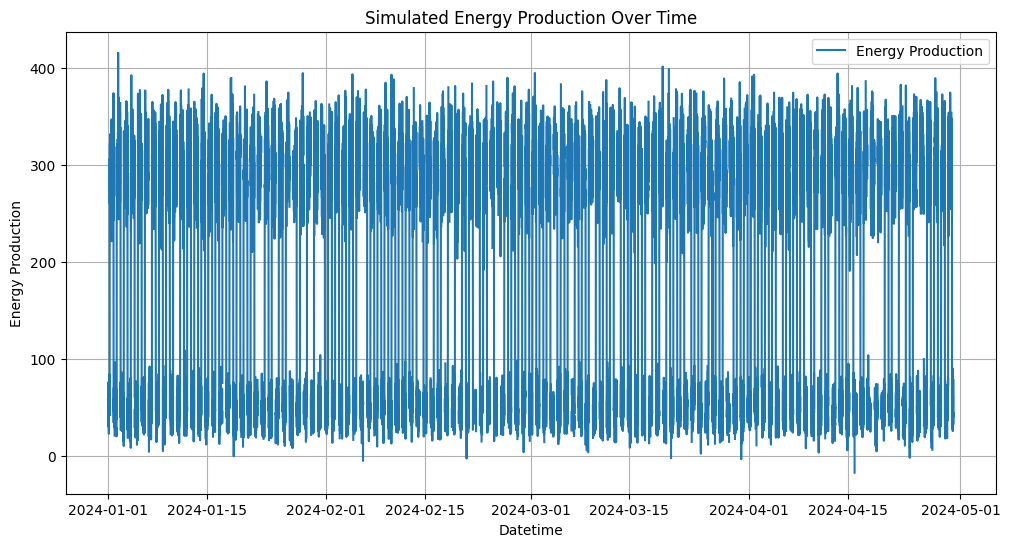

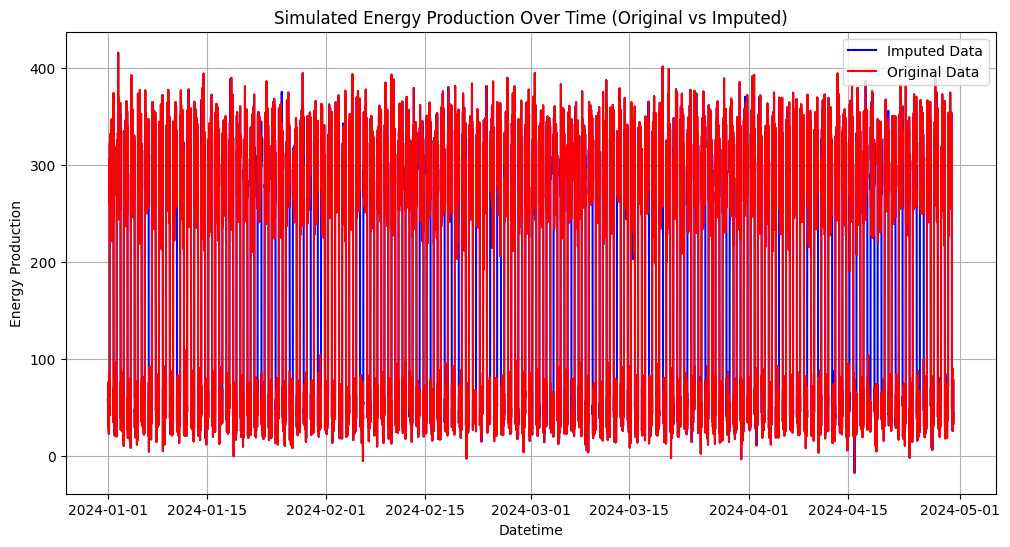

  Metric  Original Data  Imputed Data
0  count   15553.000000  17281.000000
1   mean     185.155737    185.237898
2    std     127.062030    126.903161
3    min     -16.984058    -16.984058
4    25%      51.260972     50.965457
5    50%     257.313693    259.026122
6    75%     302.393653    302.343532
7    max     415.581945    415.581945


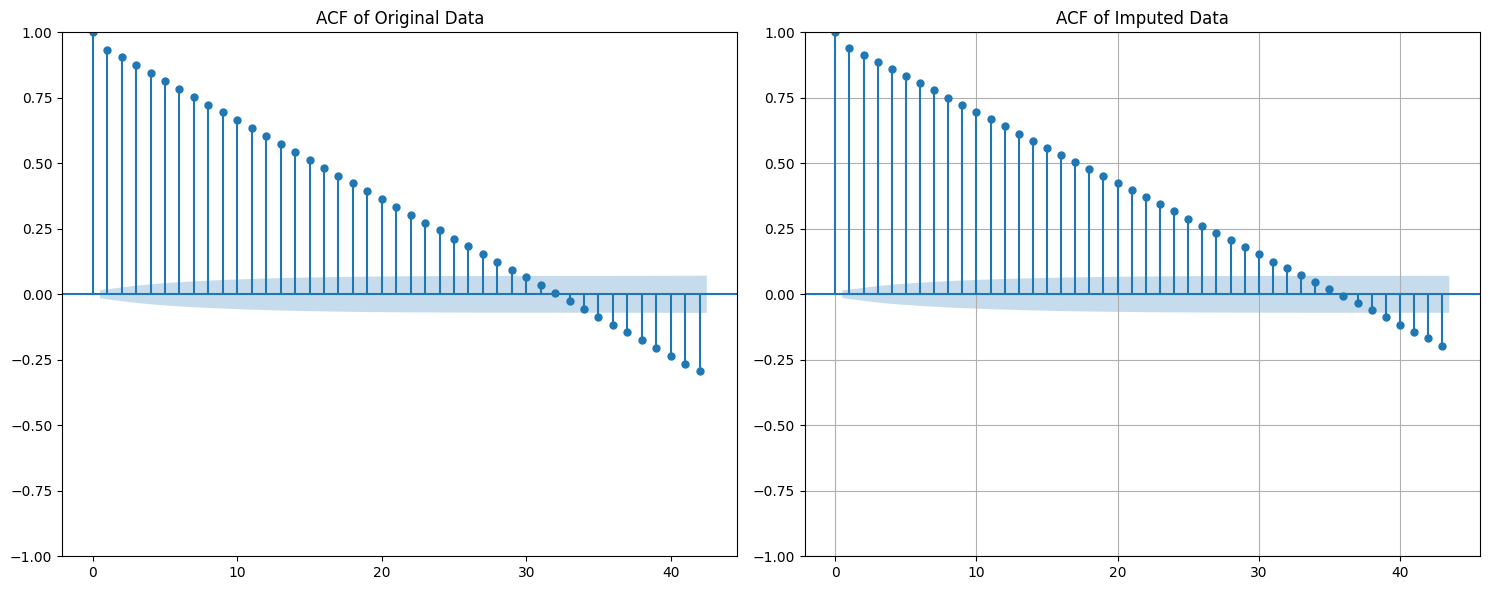

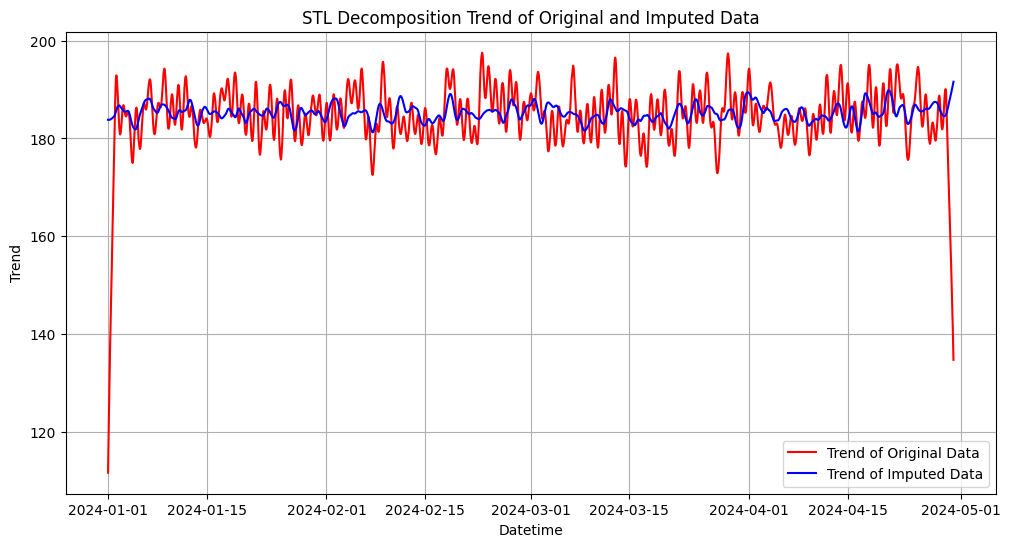

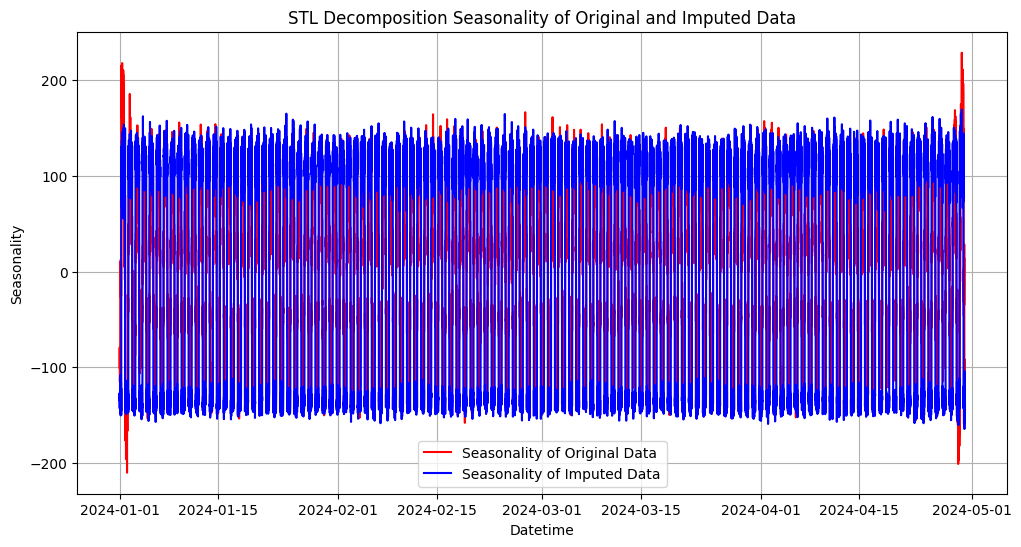

In [80]:

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Simulate mock energy production dataset
def simulate_energy_data(start_date, end_date, freq='10min'):
    # Create a datetime index with 10-minute intervals
    datetime_index = pd.date_range(start=start_date, end=end_date, freq=freq)

    # Simulate energy production with day-night cycles
    np.random.seed(42)  # For reproducibility
    hours = datetime_index.hour
    day_energy = np.random.normal(loc=300, scale=30, size=len(hours))
    night_energy = np.random.normal(loc=50, scale=15, size=len(hours))
    energy_values = np.where((hours >= 6) & (hours <= 18), day_energy, night_energy)

    # Introduce missing values (10% of the dataset)
    num_missing = int(0.1 * len(energy_values))  # 10% of data will be missing
    missing_indices = np.random.choice(len(energy_values), num_missing, replace=False)
    energy_values[missing_indices] = np.nan  # Set randomly selected indices to NaN

    # Create DataFrame with the simulated energy data
    energy_data = pd.DataFrame({
        'Datetime': datetime_index,
        'Energy_Production': energy_values
    })

    return energy_data
from sklearn.tree import DecisionTreeRegressor

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Feature engineering function
def feature_engineering(data):
    data['Hour'] = data['Datetime'].dt.hour
    data['DayOfWeek'] = data['Datetime'].dt.dayofweek
    data['Hour_Sin'] = np.sin(2 * np.pi * data['Hour'] / 24)
    data['Hour_Cos'] = np.cos(2 * np.pi * data['Hour'] / 24)
    data['Day_Sin'] = np.sin(2 * np.pi * data['DayOfWeek'] / 7)
    data['Day_Cos'] = np.cos(2 * np.pi * data['DayOfWeek'] / 7)
    return data

# Impute missing values using KNN with feature engineering
def impute_missing_values_knn(data, n_neighbors=5):
    data = feature_engineering(data)

    # Extract the non-missing data
    non_missing_data = data.dropna()

    # Prepare the features (X) and target (y)
    features = ['Hour', 'DayOfWeek', 'Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos']
    X = non_missing_data[features]
    y = non_missing_data['Energy_Production']

    # Fit the KNN model
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn.fit(X, y)

    # Predict the missing values
    missing_data = data[data['Energy_Production'].isna()]
    X_missing = missing_data[features]
    predicted_values = knn.predict(X_missing)

    # Create a DataFrame for the imputed data
    imputed_data = data.copy()
    imputed_data.loc[data['Energy_Production'].isna(), 'Energy_Production'] = predicted_values

    return imputed_data

from statsmodels.graphics.tsaplots import plot_acf

def autocorrelation_analysis(original_data, imputed_data):
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plot_acf(original_data['Energy_Production'].dropna(), ax=plt.gca(), title='ACF of Original Data')
    plt.subplot(2, 1, 2)
    plot_acf(imputed_data['Energy_Production'], ax=plt.gca(), title='ACF of Imputed Data')
    plt.tight_layout()
    plt.show()

# Autocorrelation analysis function
def autocorrelation_analysis(original_data, imputed_data):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    plot_acf(original_data['Energy_Production'].dropna(), ax=axes[0], title='ACF of Original Data')
    plot_acf(imputed_data['Energy_Production'], ax=axes[1], title='ACF of Imputed Data')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose


# STL decomposition function to extract and plot trend component
def stl_decomposition_trend(original_data, imputed_data, period):
    stl_original = STL(original_data['Energy_Production'] , period=period)
    result_original = stl_original.fit()
    trend_original = result_original.trend

    stl_imputed = STL(imputed_data['Energy_Production'], period=period)
    result_imputed = stl_imputed.fit()
    trend_imputed = result_imputed.trend

    plt.figure(figsize=(12, 6))
    plt.plot(original_data['Datetime'], trend_original, label='Trend of Original Data', color='red')
    plt.plot(imputed_data['Datetime'], trend_imputed, label='Trend of Imputed Data', color='blue')
    plt.xlabel('Datetime')
    plt.ylabel('Trend')
    plt.title('STL Decomposition Trend of Original and Imputed Data')
    plt.legend()
    plt.grid(True)
    plt.show()


def stl_decomposition_seasonality(original_data, imputed_data, period):
    stl_original = STL(original_data['Energy_Production'], period=period)
    result_original = stl_original.fit()
    seasonality_original = result_original.seasonal

    stl_imputed = STL(imputed_data['Energy_Production'], period=period)
    result_imputed = stl_imputed.fit()
    seasonality_imputed = result_imputed.seasonal

    plt.figure(figsize=(12, 6))
    plt.plot(original_data['Datetime'], seasonality_original, label='Seasonality of Original Data', color='red')
    plt.plot(imputed_data['Datetime'], seasonality_imputed, label='Seasonality of Imputed Data', color='blue')
    plt.xlabel('Datetime')
    plt.ylabel('Seasonality')
    plt.title('STL Decomposition Seasonality of Original and Imputed Data')
    plt.legend()
    plt.grid(True)
    plt.show()



def plot_origin_data(energy_data_with_missing):
    plt.figure(figsize=(12, 6))
    plt.plot(energy_data_with_missing['Datetime'], energy_data_with_missing['Energy_Production'], label='Energy Production')
    plt.xlabel('Datetime')
    plt.ylabel('Energy Production')
    plt.title('Simulated Energy Production Over Time')
    plt.legend()

    plt.grid(True)
    plt.show()

def plot_data(energy_data_imputed,energy_data_with_missing):
    plt.figure(figsize=(12, 6))

    plt.plot(energy_data_imputed['Datetime'], energy_data_imputed['Energy_Production'], label='Imputed Data', color='blue' )
    plt.plot(energy_data_with_missing['Datetime'], energy_data_with_missing['Energy_Production'], label='Original Data', color='red')
    plt.xlabel('Datetime')
    plt.ylabel('Energy Production')
    plt.title('Simulated Energy Production Over Time (Original vs Imputed)')
    plt.legend()
    plt.grid(True)
    plt.show()
# Main script
if __name__ == "__main__":

    start_date = datetime(2024, 1, 1)
    end_date = datetime(2024, 4, 30)

    # Generate the simulated dataset
    energy_data_with_missing = simulate_energy_data(start_date, end_date)

    # Impute the missing values
    energy_data_imputed = impute_missing_values_knn(energy_data_with_missing.copy())

    # Display the first few rows of the dataset
    print(energy_data_imputed.head())

    plot_origin_data(energy_data_with_missing)

    plot_data(energy_data_imputed,energy_data_with_missing)

    # Perform statistical comparison
    comparison = statistical_comparison(energy_data_with_missing.dropna(), energy_data_imputed)
    print(comparison)

    autocorrelation_analysis(energy_data_with_missing, energy_data_imputed)



    # Perform STL decomposition
    stl_decomposition_trend(energy_data_with_missing.dropna(), energy_data_imputed, period=144)  # Daily seasonality (144 10-min intervals in a day)
    stl_decomposition_seasonality(energy_data_with_missing.dropna(), energy_data_imputed, period=144)  # Daily seasonality (144 10-min intervals in a day)



             Datetime  Energy_Production  Hour  DayOfWeek  Hour_Sin  Hour_Cos  \
0 2023-01-01 00:00:00          68.135153     0          6       0.0       1.0   
1 2023-01-01 00:10:00          23.301873     0          6       0.0       1.0   
2 2023-01-01 00:20:00          48.239848     0          6       0.0       1.0   
3 2023-01-01 00:30:00          87.581734     0          6       0.0       1.0   
4 2023-01-01 00:40:00          48.239848     0          6       0.0       1.0   

    Day_Sin  Day_Cos  
0 -0.781831  0.62349  
1 -0.781831  0.62349  
2 -0.781831  0.62349  
3 -0.781831  0.62349  
4 -0.781831  0.62349  
  Metric  Original Data  Imputed Data
0  count    7648.000000   8497.000000
1   mean     185.820436    185.660584
2    std     126.762542    126.675102
3    min      -8.836004     -8.836004
4    25%      52.326459     52.032371
5    50%     257.781735    258.797913
6    75%     302.534291    302.267291
7    max     415.581945    415.581945


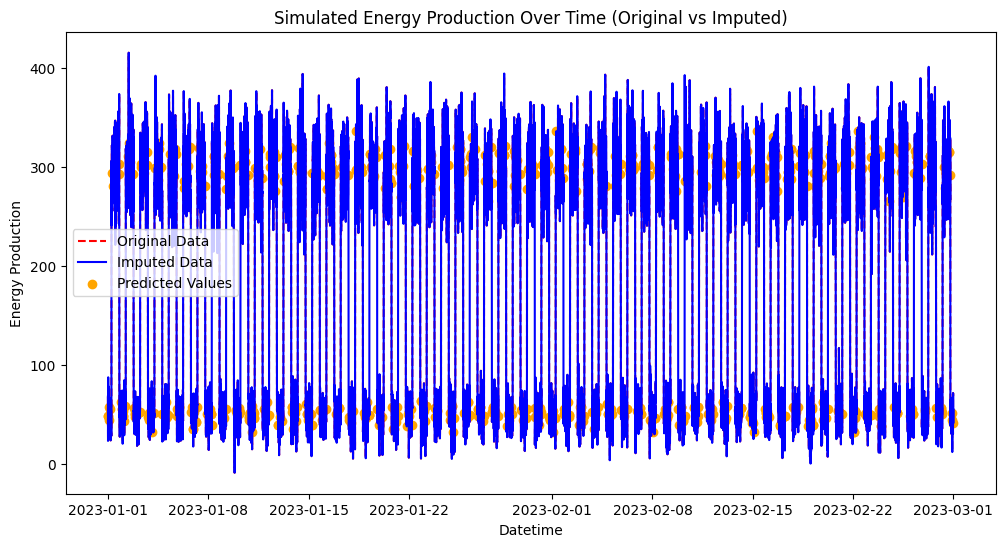

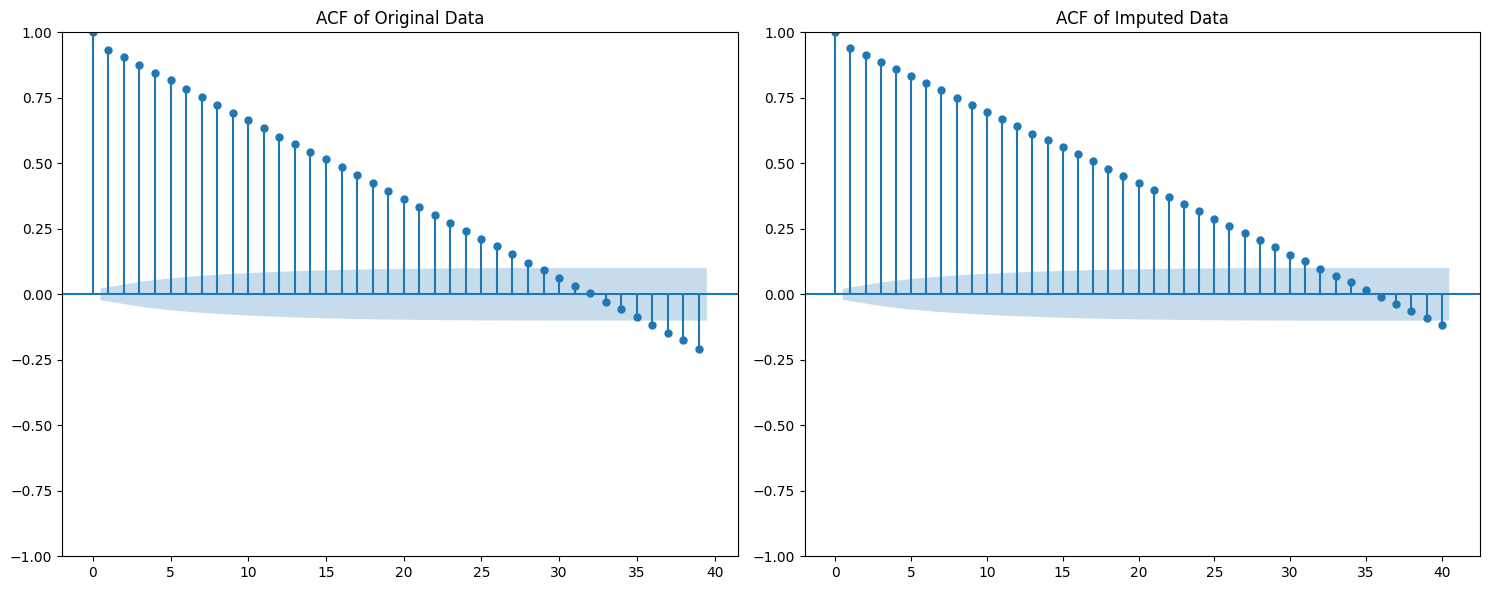

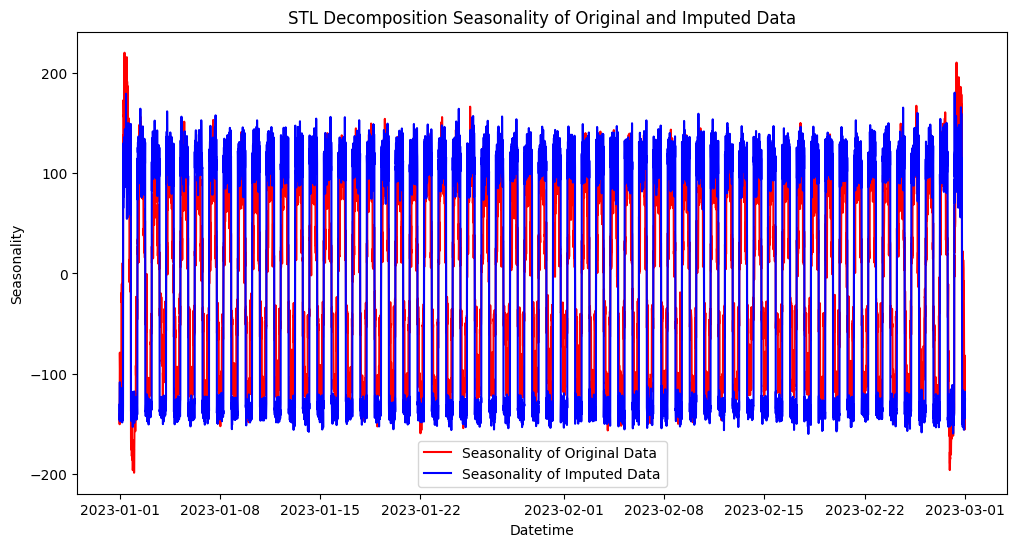

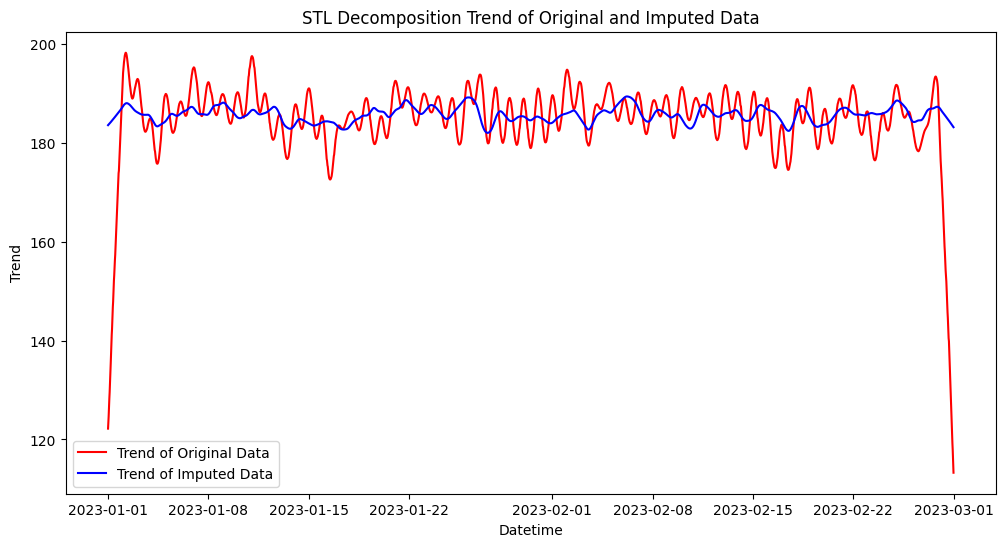

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL

# Simulate mock energy production dataset
def simulate_energy_data(start_date, end_date, freq='10min'):
    # Create a datetime index with 10-minute intervals
    datetime_index = pd.date_range(start=start_date, end=end_date, freq=freq)

    # Simulate energy production with day-night cycles
    np.random.seed(42)  # For reproducibility
    hours = datetime_index.hour
    day_energy = np.random.normal(loc=300, scale=30, size=len(hours))
    night_energy = np.random.normal(loc=50, scale=15, size=len(hours))
    energy_values = np.where((hours >= 6) & (hours <= 18), day_energy, night_energy)

    # Introduce missing values (10% of the dataset)
    num_missing = int(0.1 * len(energy_values))  # 10% of data will be missing
    missing_indices = np.random.choice(len(energy_values), num_missing, replace=False)
    energy_values[missing_indices] = np.nan  # Set randomly selected indices to NaN

    # Create DataFrame with the simulated energy data
    energy_data = pd.DataFrame({
        'Datetime': datetime_index,
        'Energy_Production': energy_values
    })

    return energy_data

# Feature engineering function
def feature_engineering(data):
    data['Hour'] = data['Datetime'].dt.hour
    data['DayOfWeek'] = data['Datetime'].dt.dayofweek
    data['Hour_Sin'] = np.sin(2 * np.pi * data['Hour'] / 24)
    data['Hour_Cos'] = np.cos(2 * np.pi * data['Hour'] / 24)
    data['Day_Sin'] = np.sin(2 * np.pi * data['DayOfWeek'] / 7)
    data['Day_Cos'] = np.cos(2 * np.pi * data['DayOfWeek'] / 7)
    return data

# Impute missing values using KNN with feature engineering
def impute_missing_values_knn(data, n_neighbors=5):
    data = feature_engineering(data)

    # Extract the non-missing data
    non_missing_data = data.dropna()

    # Prepare the features (X) and target (y)
    features = ['Hour', 'DayOfWeek', 'Hour_Sin', 'Hour_Cos', 'Day_Sin', 'Day_Cos']
    X = non_missing_data[features]
    y = non_missing_data['Energy_Production']

    # Fit the KNN model
    knn = KNeighborsRegressor(n_neighbors=n_neighbors)
    knn.fit(X, y)

    # Predict the missing values
    missing_data = data[data['Energy_Production'].isna()]
    X_missing = missing_data[features]
    predicted_values = knn.predict(X_missing)

    # Create a DataFrame for the imputed data
    imputed_data = data.copy()
    imputed_data.loc[data['Energy_Production'].isna(), 'Energy_Production'] = predicted_values

    return imputed_data, predicted_values, missing_data['Datetime']

# Statistical comparison function using describe
def statistical_comparison(original_data, imputed_data):
    original_stats = original_data['Energy_Production'].describe()
    imputed_stats = imputed_data['Energy_Production'].describe()
    comparison = pd.DataFrame({
        'Metric': original_stats.index,
        'Original Data': original_stats.values,
        'Imputed Data': imputed_stats.values
    })
    return comparison

# Autocorrelation analysis function
def autocorrelation_analysis(original_data, imputed_data):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    plot_acf(original_data['Energy_Production'].dropna(), ax=axes[0], title='ACF of Original Data')
    plot_acf(imputed_data['Energy_Production'], ax=axes[1], title='ACF of Imputed Data')
    plt.tight_layout()
    plt.show()

# STL decomposition function to extract and plot seasonality component
def stl_decomposition_seasonality(original_data, imputed_data, period):
    stl_original = STL(original_data['Energy_Production'], period=period)
    result_original = stl_original.fit()
    seasonality_original = result_original.seasonal

    stl_imputed = STL(imputed_data['Energy_Production'], period=period)
    result_imputed = stl_imputed.fit()
    seasonality_imputed = result_imputed.seasonal

    plt.figure(figsize=(12, 6))
    plt.plot(original_data['Datetime'], seasonality_original, label='Seasonality of Original Data', color='red')
    plt.plot(imputed_data['Datetime'], seasonality_imputed, label='Seasonality of Imputed Data', color='blue')
    plt.xlabel('Datetime')
    plt.ylabel('Seasonality')
    plt.title('STL Decomposition Seasonality of Original and Imputed Data')
    plt.legend()
    plt.show()

# STL decomposition function to extract and plot trend component
def stl_decomposition_trend(original_data, imputed_data, period):
    stl_original = STL(original_data['Energy_Production'], period=period)
    result_original = stl_original.fit()
    trend_original = result_original.trend

    stl_imputed = STL(imputed_data['Energy_Production'], period=period)
    result_imputed = stl_imputed.fit()
    trend_imputed = result_imputed.trend

    plt.figure(figsize=(12, 6))
    plt.plot(original_data['Datetime'], trend_original, label='Trend of Original Data', color='red')
    plt.plot(imputed_data['Datetime'], trend_imputed, label='Trend of Imputed Data', color='blue')
    plt.xlabel('Datetime')
    plt.ylabel('Trend')
    plt.title('STL Decomposition Trend of Original and Imputed Data')
    plt.legend()
    plt.show()

# Main script
if __name__ == "__main__":
    start_date = datetime(2023, 1, 1)
    end_date = datetime(2023, 3, 1)

    # Generate the simulated dataset
    energy_data_with_missing = simulate_energy_data(start_date, end_date)

    # Impute the missing values using KNN
    energy_data_imputed, predicted_values, missing_datetimes = impute_missing_values_knn(energy_data_with_missing.copy())

    # Display the first few rows of the dataset
    print(energy_data_imputed.head())

    # Perform statistical comparison
    comparison = statistical_comparison(energy_data_with_missing.dropna(), energy_data_imputed)
    print(comparison)

    # Plot the energy production data
    plt.figure(figsize=(12, 6))
    plt.plot(energy_data_with_missing['Datetime'], energy_data_with_missing['Energy_Production'], label='Original Data', linestyle='--', color='red')
    plt.plot(energy_data_imputed['Datetime'], energy_data_imputed['Energy_Production'], label='Imputed Data', color='blue')
    plt.scatter(missing_datetimes, predicted_values, color='orange', label='Predicted Values')
    plt.xlabel('Datetime')
    plt.ylabel('Energy Production')
    plt.title('Simulated Energy Production Over Time (Original vs Imputed)')
    plt.legend()
    plt.show()

    # Perform autocorrelation analysis
    autocorrelation_analysis(energy_data_with_missing, energy_data_imputed)

    # Perform STL decomposition to extract and plot seasonality component
    stl_decomposition_seasonality(energy_data_with_missing.dropna(), energy_data_imputed, period=144)

    # Perform STL decomposition to extract and plot trend component
    stl_decomposition_trend(energy_data_with_missing.dropna(), energy_data_imputed, period=144)